# Introduction  

This notebook presents a comprehensive solution for the **"Predicting Road Accident Risk"** Kaggle competition.  
We'll walk through every step of the machine learning pipeline, from **data exploration** to **model training and evaluation**, with detailed explanations designed for both beginners and intermediate learners.  

---

## What is Road Accident Risk?  

Road accident risk is a **probability score** that estimates the likelihood of an accident occurring under certain conditions.  
This risk depends on multiple factors such as:  

- **Road conditions** – road type, curvature, number of lanes, and speed limits  
- **Environmental factors** – lighting, weather, and time of day  
- **Traffic and infrastructure** – presence of road signs, whether it is a public road  
- **Situational aspects** – holidays, school season, and reported accidents  

By analyzing these variables, we aim to predict the **`accident_risk`**, which can be used to **improve road safety measures, guide policy decisions, and assist autonomous driving systems**.  

---

## Competition Objective  

Our goal is to **predict the accident risk score (`accident_risk`)** for given road and environmental conditions.  
Success is measured by how closely our predictions match the actual values, typically evaluated with an error-based metric such as **Root Mean Squared Error (RMSE)**.  

---

## Important Note on This Dataset  

This dataset contains **517,754 records** with **14 features**, combining categorical (road type, weather, time of day, etc.) and numerical variables (curvature, speed limit, accident counts).  
While the dataset is synthetic and may not perfectly reflect real-world accident data, it provides a rich and balanced environment for testing machine learning approaches to **risk prediction**.  

---

Let’s begin our journey towards building a reliable predictive model for road accident risk 🚦!


In [1]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


# 1. Setup & data loading

In [2]:

# ====================================================
# Setup & Imports
# ====================================================

# Standard Libraries
import os
import warnings
import random

# Data Manipulation & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

# Gradient Boosting Models
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Settings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# ====================================================
# Load Data
# ====================================================
try:
    test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")
    train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
    sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")

    print("Dataset Shapes:")
    print("Train:", train.shape)
    print("Test:", test.shape)
    print("Sample Submission:", sample_submission.shape)
    print()
except FileNotFoundError as e:
    print(f"⚠️ Error loading files: {e}")
    print("Please ensure train.csv, test.csv, and sample_submission.csv are available in the working directory.")


Dataset Shapes:
Train: (517754, 14)
Test: (172585, 13)
Sample Submission: (172585, 2)



# 2. Exploratory data analysis


## 2.1 Understanding the Features  

Before diving into the data, let’s review what each feature represents in the context of **road safety 🚦**.  

<table>
  <thead style="background-color:#4CAF50; color:white;">
    <tr>
      <th style="padding:8px;">Feature</th>
      <th style="padding:8px;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>id</b></td>
      <td>Unique identifier for each road segment in the dataset</td>
    </tr>
    <tr>
      <td><b>road_type</b></td>
      <td>Category of the road: e.g., <i>urban, rural, highway</i></td>
    </tr>
    <tr>
      <td><b>num_lanes</b></td>
      <td>Number of lanes on the road segment</td>
    </tr>
    <tr>
      <td><b>curvature</b></td>
      <td>Measure of how curved the road is (0 = straight, higher values = sharper turns)</td>
    </tr>
    <tr>
      <td><b>speed_limit</b></td>
      <td>Maximum legal speed allowed on the segment (in km/h)</td>
    </tr>
    <tr>
      <td><b>lighting</b></td>
      <td>Lighting conditions: <i>daylight, dim, etc.</i></td>
    </tr>
    <tr>
      <td><b>weather</b></td>
      <td>Weather at the time: <i>clear, rainy, foggy, etc.</i></td>
    </tr>
    <tr>
      <td><b>road_signs_present</b></td>
      <td>Whether traffic/road signs are present (<code>True/False</code>)</td>
    </tr>
    <tr>
      <td><b>public_road</b></td>
      <td>Indicates if it is a public road (<code>True/False</code>)</td>
    </tr>
    <tr>
      <td><b>time_of_day</b></td>
      <td>Categorical feature: <i>morning, afternoon, evening, night</i></td>
    </tr>
    <tr>
      <td><b>holiday</b></td>
      <td>Whether the observation falls on a holiday (<code>True/False</code>)</td>
    </tr>
    <tr>
      <td><b>school_season</b></td>
      <td>Whether the observation falls during a school season (<code>True/False</code>)</td>
    </tr>
    <tr>
      <td><b>num_reported_accidents</b></td>
      <td>Number of historical accidents reported for the segment</td>
    </tr>
    <tr>
      <td><b>accident_risk</b></td>
      <td>🎯 <b>Target variable</b> – Predicted probability/risk score of an accident</td>
    </tr>
  </tbody>
</table>  

---

🔎 **Why these features matter**:  
- Roads with **more lanes** and **higher speed limits** may be more prone to accidents.  
- **Curvature** affects driving safety – sharp turns increase accident risk.  
- **Lighting** and **weather** are crucial visibility factors impacting safety.  
- **Road signs** and **public road status** provide context for infrastructure safety.  
- **Time of day, holidays, and school season** capture temporal risk variations.  
- **Reported accident counts** offer historical evidence of dangerous spots.  

Together, these features help us model how different **road, environmental, and situational conditions** influence the likelihood of accidents.  


## 2.2 Data information

In [3]:
def data_info(df, df_name):
    """Comprehensive overview of a DataFrame with styled output."""




    print(f"\n{'='*70}")
    print(f"📊 Comprehensive Information for DataFrame: {df_name}")
    print(f"{'='*70}\n")

    # --- Head & Tail ---
    print(f"--- {df_name} Head ---\n")
    display(df.head().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))


    # --- Info ---
    print(f"\n--- {df_name} Info ---\n")
    df.info()

    # --- Describe (numeric + categorical) ---
    print(f"\n--- {df_name} Describe (Numeric) ---\n")
    display(df.describe().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    print(f"\n--- {df_name} Describe (All Columns) ---\n")
    display(df.describe(include='all').transpose().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Missing Values ---
    print(f"\n--- {df_name} Missing Values ---\n")
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("✅ No missing values found.")
    else:
        missing_df = pd.DataFrame({
            'Missing Count': missing,
            'Missing %': (missing / len(df)) * 100
        }).query("`Missing Count` > 0")

        display(missing_df.style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    print(f"\n{'='*70}\n")

# Apply to datasets
data_info(train, "train")
data_info(test, "test")


📊 Comprehensive Information for DataFrame: train

--- train Head ---



,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.060000,35,daylight,rainy,False,True,afternoon,False,True,1,0.130000
1,1,urban,4,0.990000,35,daylight,clear,True,False,evening,True,True,0,0.350000
2,2,rural,4,0.630000,70,dim,clear,False,True,morning,True,False,2,0.300000
3,3,highway,4,0.070000,35,dim,rainy,True,True,morning,False,False,1,0.210000
4,4,rural,1,0.580000,60,daylight,foggy,False,False,evening,True,False,1,0.560000



--- train Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtyp

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000



--- train Describe (All Columns) ---



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,517754.000000,nan,nan,nan,258876.500000,149462.849974,0.000000,129438.250000,258876.500000,388314.750000,517753.000000
road_type,517754,3,highway,173672,nan,nan,nan,nan,nan,nan,nan
num_lanes,517754.000000,nan,nan,nan,2.491511,1.120434,1.000000,1.000000,2.000000,3.000000,4.000000
curvature,517754.000000,nan,nan,nan,0.488719,0.272563,0.000000,0.260000,0.510000,0.710000,1.000000
speed_limit,517754.000000,nan,nan,nan,46.112575,15.788521,25.000000,35.000000,45.000000,60.000000,70.000000
lighting,517754,3,dim,183826,nan,nan,nan,nan,nan,nan,nan
weather,517754,3,foggy,181463,nan,nan,nan,nan,nan,nan,nan
road_signs_present,517754,2,False,259289,nan,nan,nan,nan,nan,nan,nan
public_road,517754,2,True,260045,nan,nan,nan,nan,nan,nan,nan
time_of_day,517754,3,morning,173410,nan,nan,nan,nan,nan,nan,nan



--- train Missing Values ---

✅ No missing values found.



📊 Comprehensive Information for DataFrame: test

--- test Head ---



,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.340000,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.040000,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.590000,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.950000,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.860000,35,daylight,clear,True,False,evening,False,True,3



--- test Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   road_type               172585 non-null  object 
 2   num_lanes               172585 non-null  int64  
 3   curvature               172585 non-null  float64
 4   speed_limit             172585 non-null  int64  
 5   lighting                172585 non-null  object 
 6   weather                 172585 non-null  object 
 7   road_signs_present      172585 non-null  bool   
 8   public_road             172585 non-null  bool   
 9   time_of_day             172585 non-null  object 
 10  holiday                 172585 non-null  bool   
 11  school_season           172585 non-null  bool   
 12  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(4), object(4)
memory usa

,id,num_lanes,curvature,speed_limit,num_reported_accidents
count,172585.000000,172585.000000,172585.000000,172585.000000,172585.000000
mean,604046.000000,2.494046,0.487263,46.102761,1.186059
std,49821.142441,1.119148,0.272343,15.787077,0.897161
min,517754.000000,1.000000,0.000000,25.000000,0.000000
25%,560900.000000,1.000000,0.260000,35.000000,1.000000
50%,604046.000000,2.000000,0.510000,45.000000,1.000000
75%,647192.000000,3.000000,0.710000,60.000000,2.000000
max,690338.000000,4.000000,1.000000,70.000000,7.000000



--- test Describe (All Columns) ---



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,172585.000000,nan,nan,nan,604046.000000,49821.142441,517754.000000,560900.000000,604046.000000,647192.000000,690338.000000
road_type,172585,3,highway,58080,nan,nan,nan,nan,nan,nan,nan
num_lanes,172585.000000,nan,nan,nan,2.494046,1.119148,1.000000,1.000000,2.000000,3.000000,4.000000
curvature,172585.000000,nan,nan,nan,0.487263,0.272343,0.000000,0.260000,0.510000,0.710000,1.000000
speed_limit,172585.000000,nan,nan,nan,46.102761,15.787077,25.000000,35.000000,45.000000,60.000000,70.000000
lighting,172585,3,dim,61143,nan,nan,nan,nan,nan,nan,nan
weather,172585,3,foggy,60236,nan,nan,nan,nan,nan,nan,nan
road_signs_present,172585,2,False,87093,nan,nan,nan,nan,nan,nan,nan
public_road,172585,2,True,86673,nan,nan,nan,nan,nan,nan,nan
time_of_day,172585,3,morning,57747,nan,nan,nan,nan,nan,nan,nan



--- test Missing Values ---

✅ No missing values found.




## 2.3 Numerical/Categorical Feature Identification




In [4]:
# Define excluded features
excluded_features = ['id', 'accident_risk'] # Exclude 'id' and the target variable

# Separate numerical and categorical features
numerical_features = [
    col for col in train.select_dtypes(include=np.number).columns
    if col not in excluded_features
]

categorical_features = [
    col for col in train.select_dtypes(exclude=np.number).columns
    if col not in excluded_features
]

# Print results
print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")

Numerical Features (4): ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
Categorical Features (8): ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']


## 2.4 Correlation Heatmap

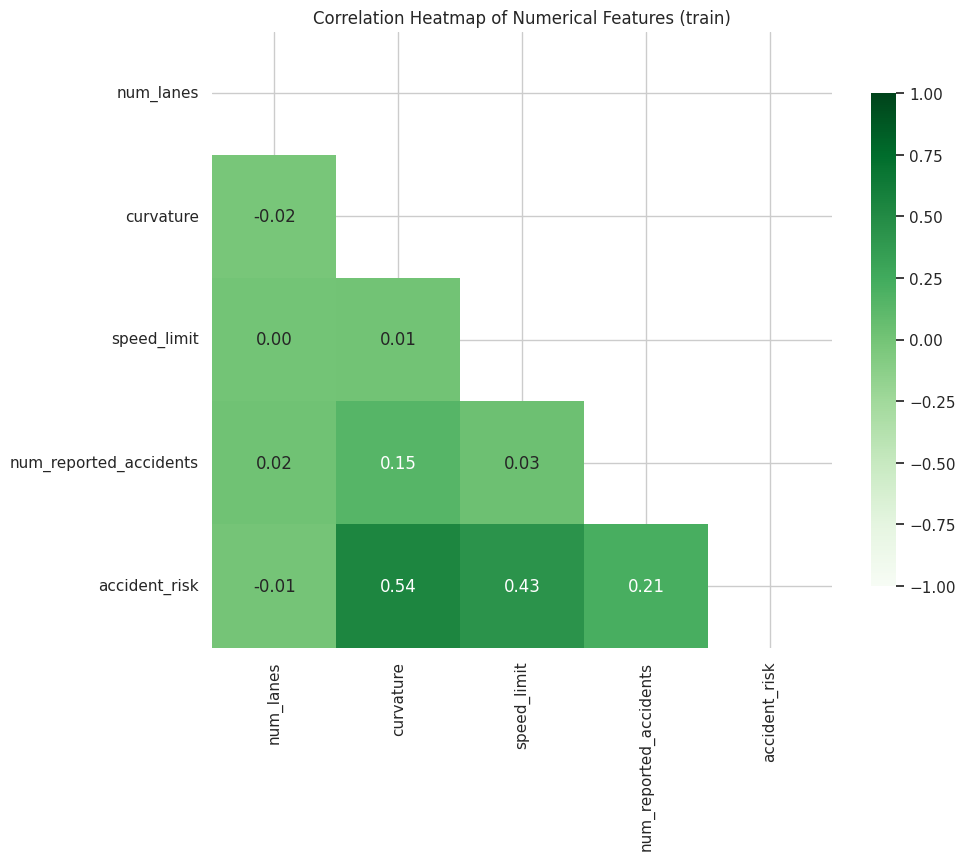

In [5]:
def plot_correlation_heatmap(df, numerical_cols, df_name, annot=True):
    """
    Generates and displays a correlation heatmap for specified numerical columns,
    showing only the lower triangle.
    """
    corr = df[numerical_cols].corr()

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr,
        mask=mask,
        annot=annot,
        cmap='Greens',
        fmt=".2f",
        vmin=-1, vmax=1,
        cbar_kws={"shrink": .8}
    )
    plt.title(f'Correlation Heatmap of Numerical Features ({df_name})')
    plt.show()

# Add target for correlation analysis
numerical_features_with_target = numerical_features + ['accident_risk']

plot_correlation_heatmap(train, numerical_features_with_target, "train")

## 2.5 Numerical Feature Distributions (Train vs Test)

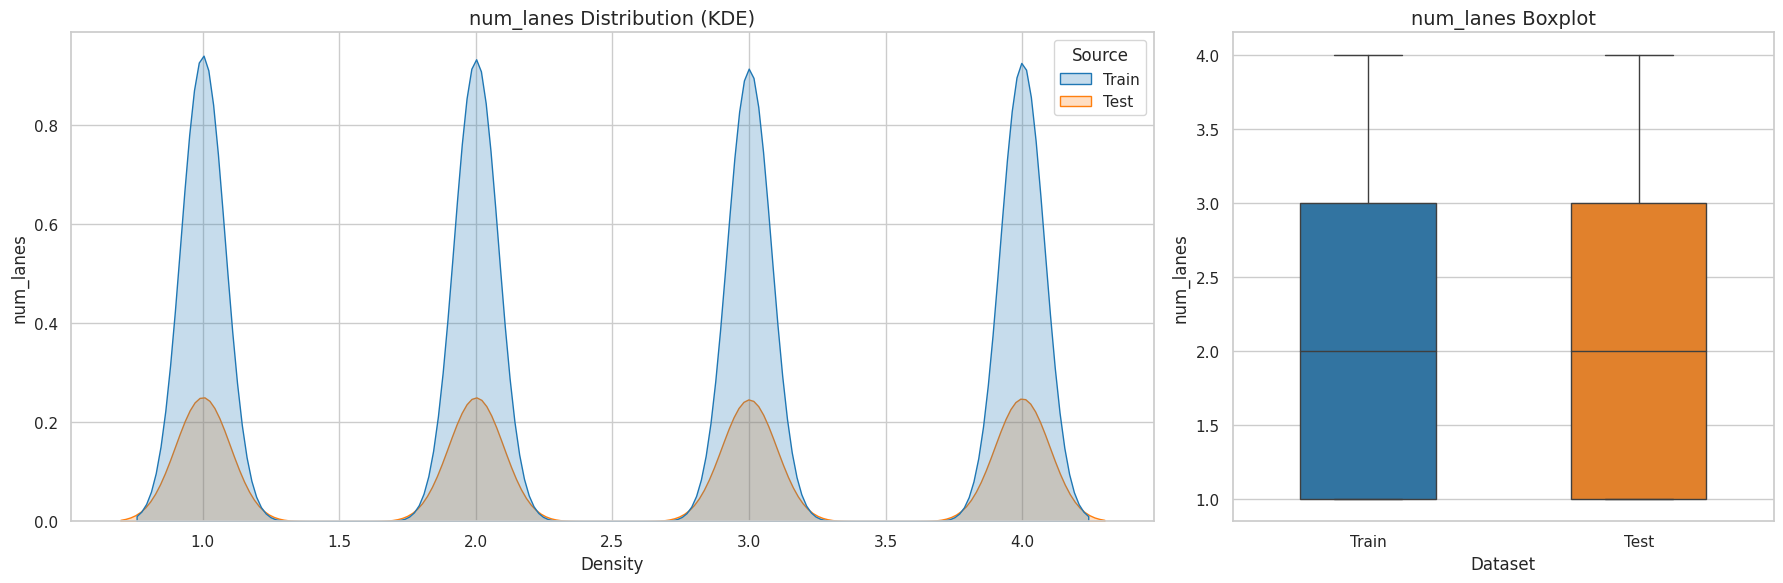

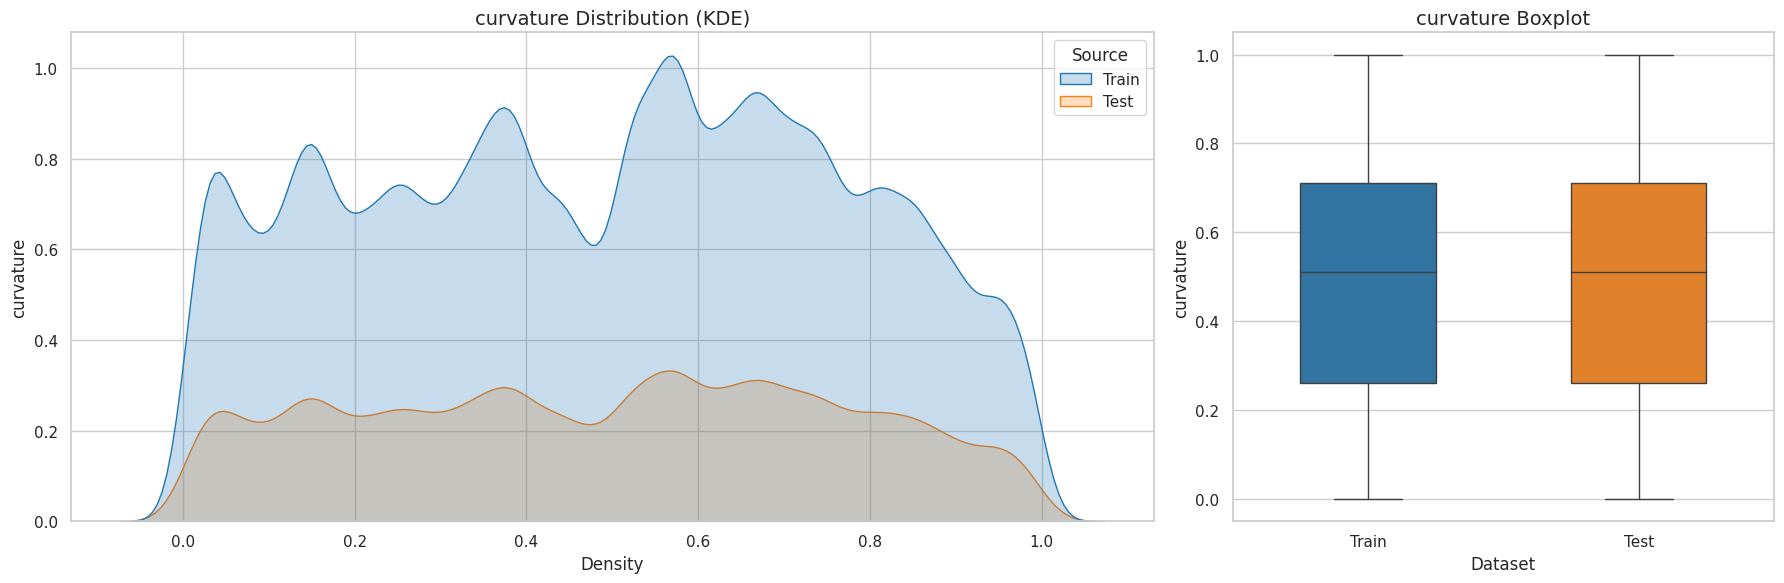

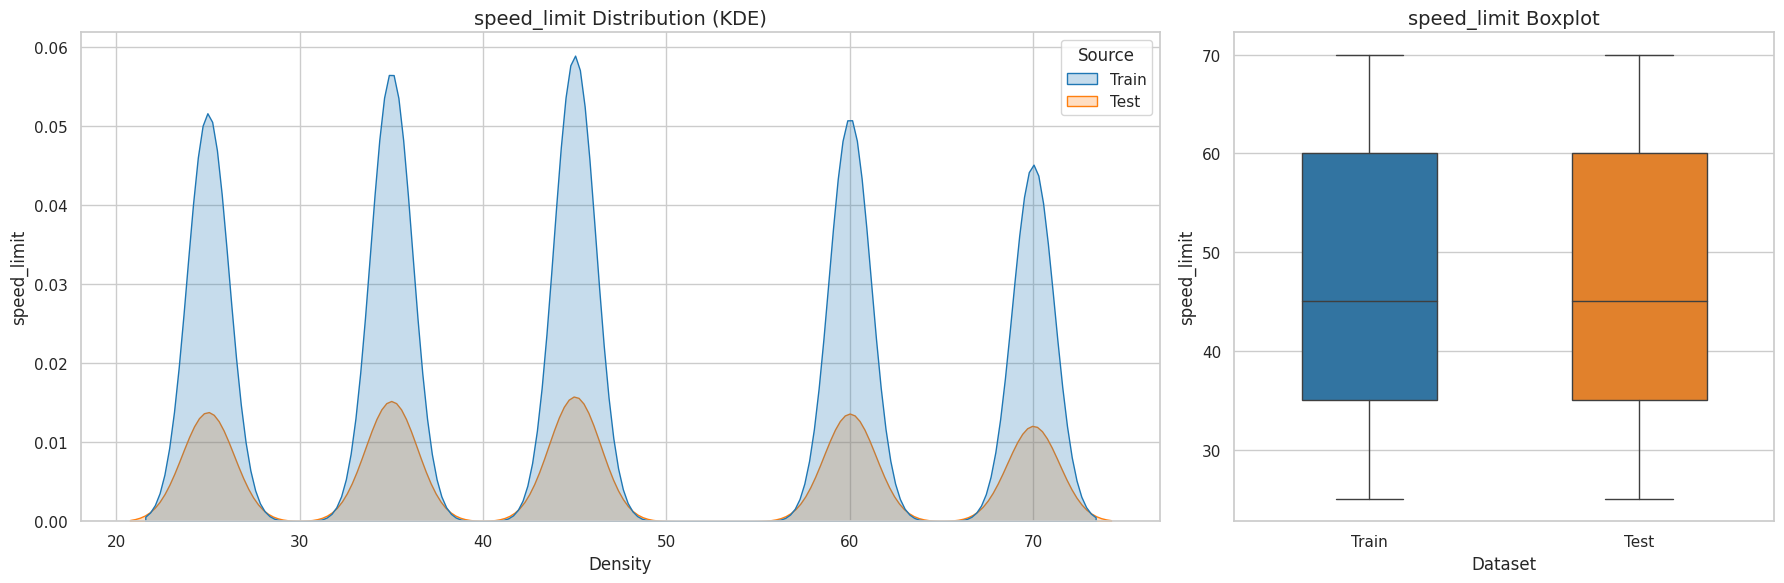

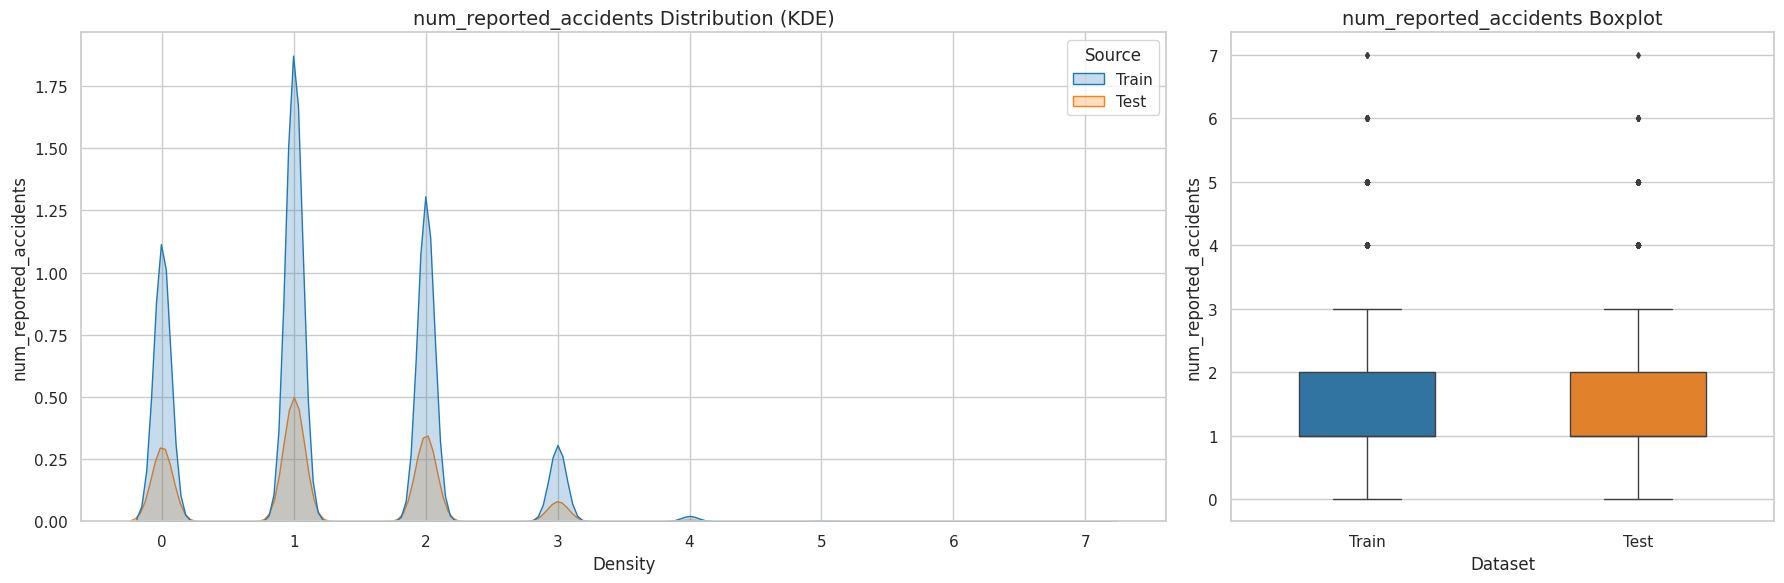

In [6]:
def plot_numerical_distributions(train_df, test_df, numerical_cols):
    """
    Generates KDE and box plots for numerical features, comparing train vs test distributions.
    """
    sns.set_style("whitegrid")
    sns.set_context("notebook")

    # Combine train and test for plotting
    combined_df = pd.concat([
        train_df[numerical_cols].assign(Source='Train'),
        test_df[numerical_cols].assign(Source='Test')
    ], axis=0, ignore_index=True)

    palette = ['#1f77b4', '#ff7f0e']  # Distinct colors for Train/Test

    for col in numerical_cols:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

        # KDE Plot
        sns.kdeplot(
            data=combined_df, x=col, hue='Source', ax=axes[0], fill=True, palette=palette
        )
        axes[0].set_title(f'{col} Distribution (KDE)', fontsize=14)
        axes[0].set_xlabel('Density')
        axes[0].set_ylabel(col)

        # Box Plot
        sns.boxplot(
            data=combined_df, y=col, x='Source', ax=axes[1],
            orient='v', width=0.5, linewidth=1, fliersize=3, palette=palette
        )
        axes[1].set_title(f'{col} Boxplot', fontsize=14)
        axes[1].set_xlabel('Dataset')
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

# Call the function for numerical features
plot_numerical_distributions(train, test, numerical_features)

## 2.6 Categorical Feature Distributions (Train vs Test)




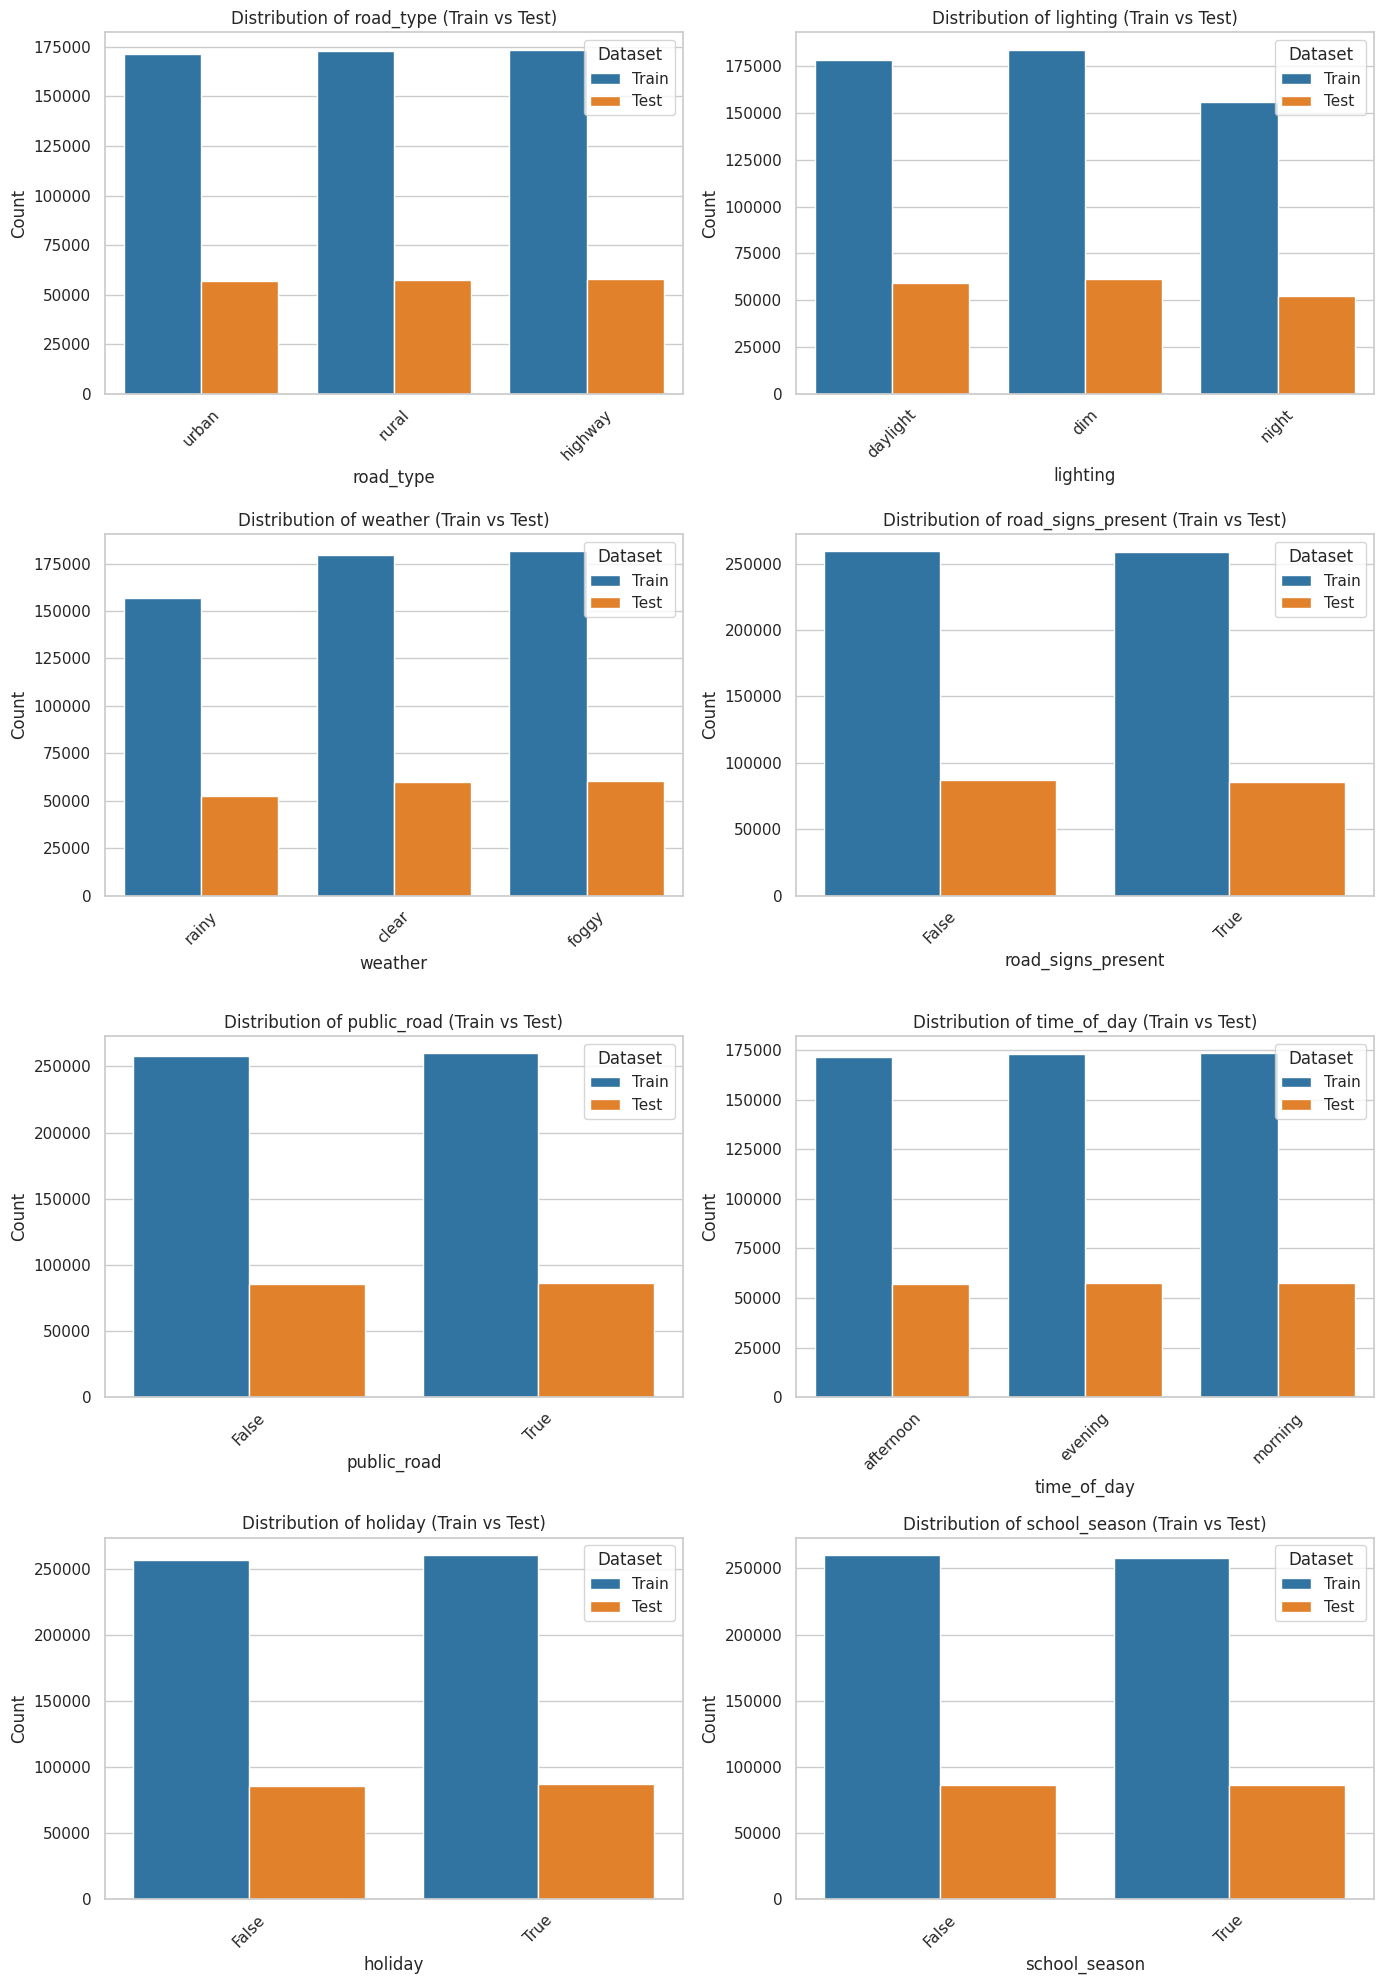

In [7]:
def plot_categorical_distributions(train_df, test_df, categorical_cols):
    """
    Generates count plots for each categorical feature, comparing train and test distributions.
    Uses a denser layout with 2 plots per row.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    palette = ['#1f77b4', '#ff7f0e']  # Train / Test colors
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten() # Flatten the axes array for easy iteration

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Combine train and test with a source column
        combined = pd.concat([
            train_df[[col]].assign(Source='Train'),
            test_df[[col]].assign(Source='Test')
        ], axis=0, ignore_index=True)

        sns.countplot(x=col, hue='Source', data=combined, palette=palette, ax=ax)

        ax.set_title(f'Distribution of {col} (Train vs Test)', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.legend(title='Dataset')
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function
plot_categorical_distributions(train, test, categorical_features)

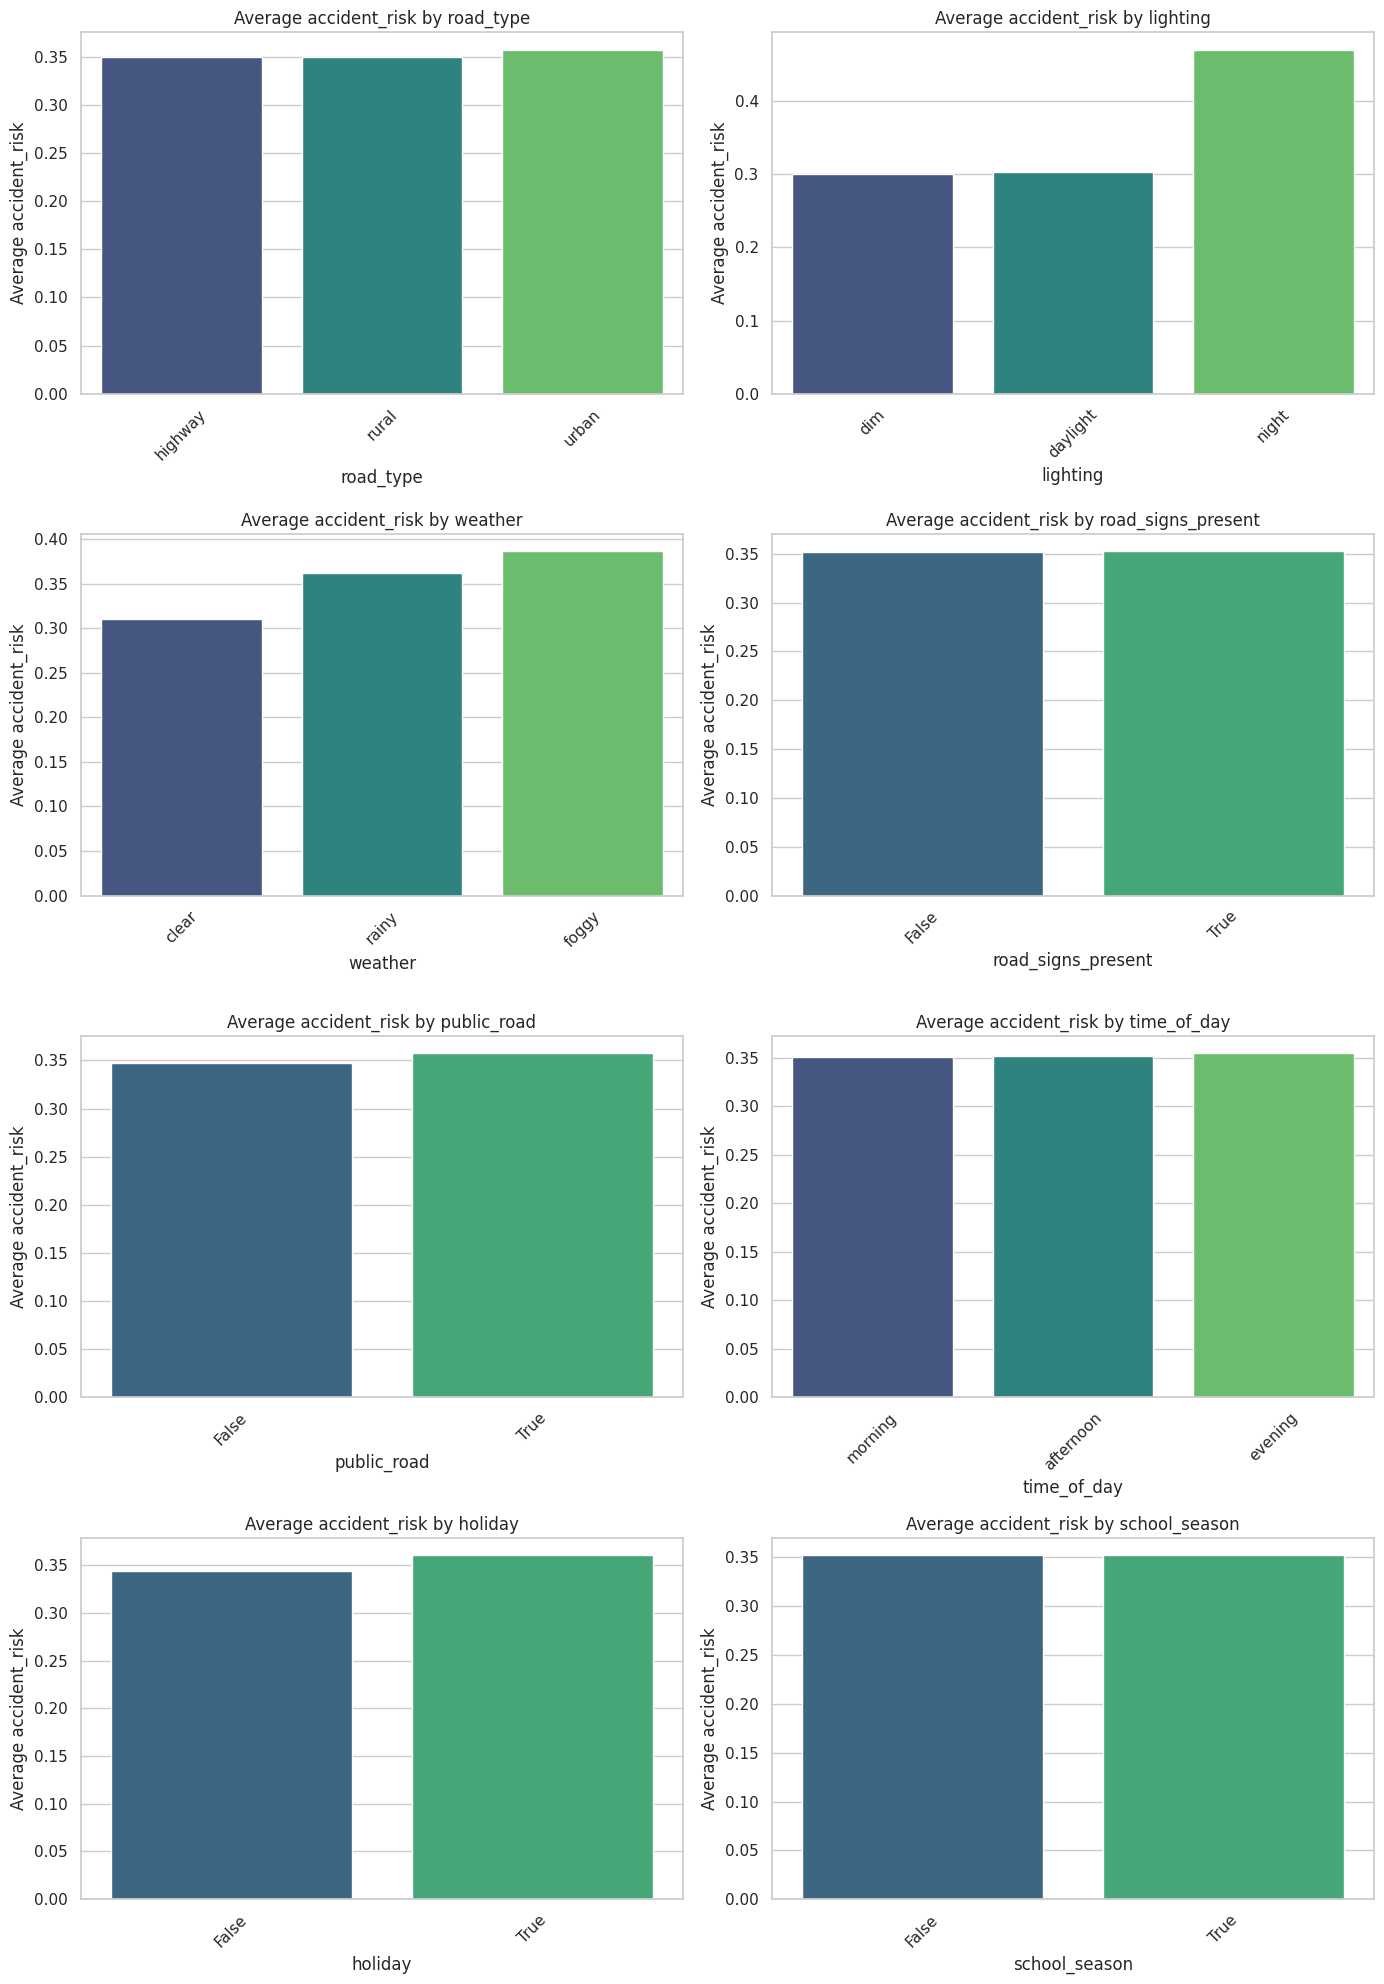

In [8]:
def plot_average_risk_by_category(train_df, categorical_cols, target_col):
    """
    Generates bar plots showing the average target value for each category
    in the specified categorical columns.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten() # Flatten the axes array

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Calculate average target value per category
        avg_risk = train_df.groupby(col)[target_col].mean().sort_values()

        sns.barplot(x=avg_risk.index, y=avg_risk.values, ax=ax, palette='viridis')

        ax.set_title(f'Average {target_col} by {col}', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel(f'Average {target_col}')
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function
plot_average_risk_by_category(train, categorical_features, 'accident_risk')

## 2.7 Target Variable Distribution

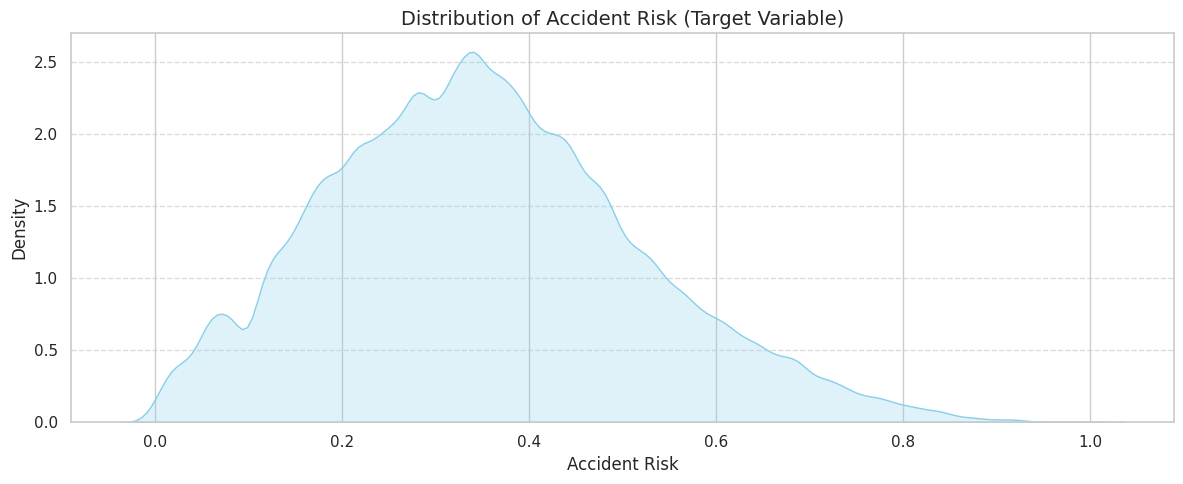

In [9]:
plt.figure(figsize=(12, 5))
sns.kdeplot(data=train, x='accident_risk', palette='viridis', fill=True, color='skyblue')
plt.title("Distribution of Accident Risk (Target Variable)", fontsize=14)
plt.xlabel("Accident Risk")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()